# Exploratory Analysis of BSS State and Trends

This notebook will provide the initial exploration and orientation with the BSS, and outputs may feature in the report. 

Note, at the time of writing the latest record is 2020-04-12 23:59

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import getcwd, chdir

In [2]:
# work from the project root
if getcwd()[-9:] == 'notebooks':
    chdir("..")

In [3]:
# connect to sqlite database
DBPATH = "data/bike_db.db"
db = sqlite3.connect(DBPATH)

## Explore monthly journey volumes

In [4]:
# Select Monthly-aggregated journey data
query = """
    SELECT
        year
        ,month
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year >= 2012
    GROUP BY 1,2
    ORDER BY 1,2
"""

mth_df = pd.read_sql_query(query, db)

In [5]:
# Merge year and month col into a proper datetime index
mth_df = mth_df.set_index(pd.to_datetime(mth_df[['year','month']].assign(day=1)))

In [6]:
def journey_plot(df, title='journeys', ylab='journeys'):
    ax = df.journeys.plot(
        figsize=(10,5)
        ,title=title
        ,grid=True);
    ax.set_ylabel(ylab);
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);

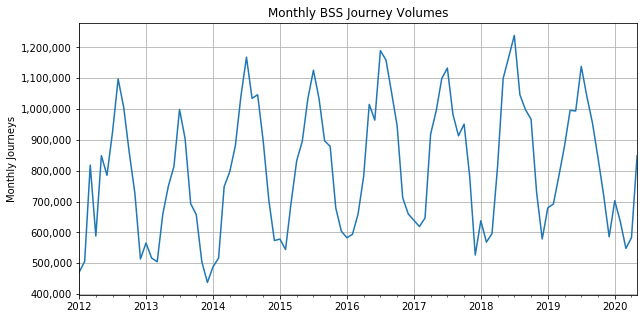

In [7]:
journey_plot(mth_df, 'Monthly BSS Journey Volumes', 'Monthly Journeys')

## Inspect 2020 at the daily level

In [8]:
# This fetches minute-ly data which we'll down-sample
df_20 = pd.read_sql_query("""
    SELECT
        "Start Date" AS start_date
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
    GROUP BY 1
    """, db)

In [9]:
df_20['start_date'] = pd.to_datetime(df_20.start_date)
df_20.set_index('start_date', inplace=True)

I'm also fetching 2019 as a year-on-year comparison point

In [10]:
# This fetches minute-ly data which we'll down-sample
df_19 = pd.read_sql_query("""
    SELECT
        "Start Date" AS start_date
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2019
        AND month <= 5
        AND "Start Date" <= "2019-05-26"
    GROUP BY 1
    """, db)

In [11]:
df_19['start_date'] = pd.to_datetime(df_19.start_date)
_ = df_19.copy()
df_19.set_index('start_date', inplace=True)

In [12]:
# My hacky way of overlaying 2019 with 2020
_['start_date'] = _['start_date'].apply(lambda x: x + pd.DateOffset(years=1))
_.set_index('start_date', inplace=True)

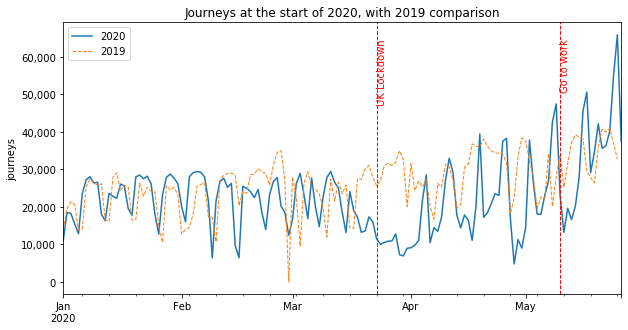

In [13]:
ax = df_20.resample('D').sum().plot(label='2020', figsize=(10,5)
                                   ,title='Journeys at the start of 2020, with 2019 comparison');
_.resample('D').sum().plot(ax = ax, label='2019', lw=1, linestyle='--');

ax.axvline(pd.to_datetime('2020-03-23'), color='r', linestyle='--', lw=1)
plt.text(pd.to_datetime('2020-03-23'),65000,'UK Lockdown',rotation=90, color='r', verticalalignment='top')

ax.axvline(pd.to_datetime('2020-05-10'), color='r', linestyle='--', lw=1)
plt.text(pd.to_datetime('2020-05-10'),65000,'Go to work',rotation=90, color='r', verticalalignment='top')

plt.legend(['2020','2019']);
ax.set_ylabel('journeys');
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax.set_xlabel(None);

In [14]:
del df_20
del df_19
del _

## Normal Daily Pattern

In [15]:
# This fetches minute-ly data which we'll down-sample
df_wkdy_hour = pd.read_sql_query("""
    SELECT
        weekday
        ,hour
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2019
    GROUP BY 1,2
    """, db)

In [71]:
def plot_hourly_weekday(df, title, ax=None, figsize=(10,5)):
    df['weekday_ind'] = 'weekday'
    df.loc[df['weekday'].isin([5,6]), 'weekday_ind'] = 'weekend'
    
    ax = df.groupby(['weekday_ind','hour']).sum()['journeys'].unstack('weekday_ind') \
    .plot(figsize=figsize
          ,title=title
          ,grid=True
          ,ax=ax);
    ax.set_ylabel('journeys');
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
    return ax

In [64]:
plot_hourly_weekday(df_wkdy_hour, title='Combined 2019 Journeys by Hour: Weekend vs Weekday');

NameError: name 'df_wkdy_hour' is not defined

In [26]:
del df_wkdy_hour

### Peek at the COVID-19 Pattern

In [18]:
# This fetches minute-ly data which we'll down-sample
df_wkdy_hour_covid = pd.read_sql_query("""
    SELECT
        weekday
        ,hour
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
        # AND month >= 3
        # AND "Start Date" >= '2020-03-23'
    GROUP BY 1,2
    """, db)

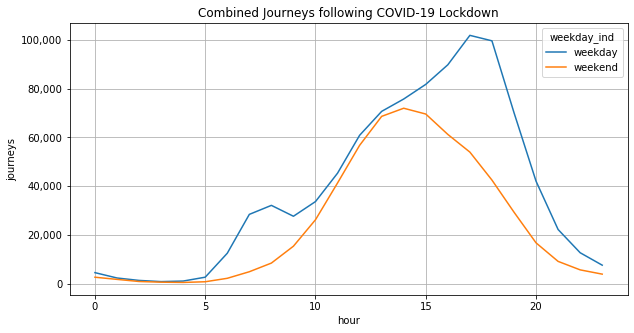

In [23]:
plot_hourly_weekday(df_wkdy_hour_covid, title='Combined Journeys following COVID-19 Lockdown');

In [31]:
del df_wkdy_hour_covid

### Evolution of 2020 by week
I will now plot one chart per week over 2020, so we can see how the usage pattern changed as the COVID-19 situation evolved. 

This isn't just interesting: it also informs us where to draw an appropriate cut-off for our time window

In [42]:
# This fetches minute-ly data which we'll down-sample
df_wkdy_hour_2020 = pd.read_sql_query("""
    SELECT
        strftime('%W', "Start Date") AS weekofyear
        ,weekday
        ,hour
        ,COUNT(*) AS journeys
    FROM
        journeys
    WHERE
        year = 2020
    GROUP BY 1,2,3
    """, db)

In [48]:
df_wkdy_hour_2020['weekofyear'] = df_wkdy_hour_2020['weekofyear'].astype(int)
df_wkdy_hour_2020['weekofyear'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

Note: ignoring week 22 as it is incomplete given data at present

Also note that week 0 is not a complete week, so weekdays have lower amplitude

In [85]:
nweeks = 21 # ignore 22
# for the subplots:
nrows = 7
ncols = 3
figsize=()

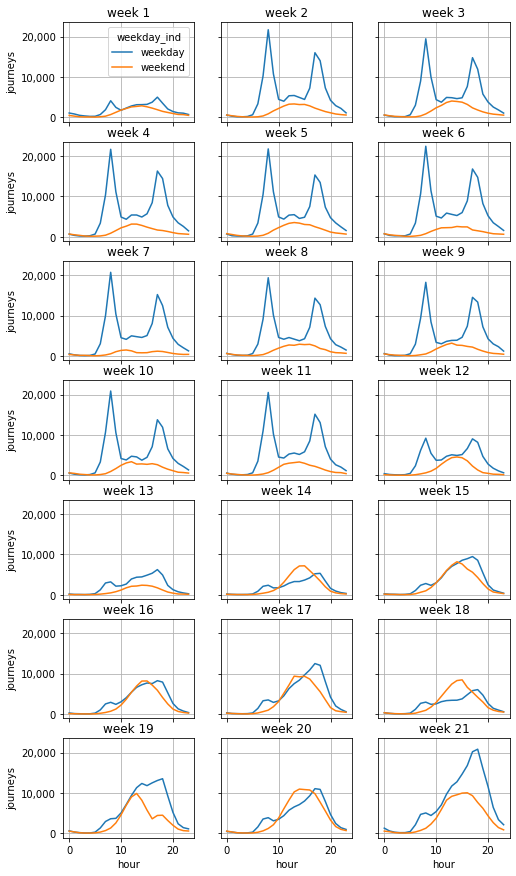

In [87]:
# Plot one weekofyear at a time

# I temporarily disable chained assignment warnings
pd.set_option('mode.chained_assignment', None)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8,15))

for i in range(nweeks):
    plot_col = (i % ncols)
    plot_row = (i // ncols)
    plot_hourly_weekday(df_wkdy_hour_2020[df_wkdy_hour_2020['weekofyear'] == i]
                        ,title='week '+str(i+1)
                        ,ax=axes[plot_row][plot_col]
                        ,figsize=None
                       );
    if i != 0:  # remove legend in all but first figure
        axes[plot_row][plot_col].get_legend().remove()

pd.set_option('mode.chained_assignment', 'raise')

Noting that week 1 was not a complete week, we see that 2020 got off to a normal start. Then week 12 (16-22 of March) is when we see a clear reaction to COVID-19. The following week the UK lockdown came into force and the weekday traffic falls away completely. 

So I propose that usage patterns should be usable up to week ending 15/03/2020.

---
# Station Availability and System Load 
System-level EDA

In [120]:
# Manually excluding one timestamp where only three bikepoints were recorded?
station_fill = pd.read_sql_query("""
    SELECT
        timestamp, bikepoint_id, docked, empty, docked + empty AS capacity
    FROM
        station_fill
    WHERE
        timestamp != "2020-06-22 10:00:00"
    """, db, parse_dates=['timestamp'])

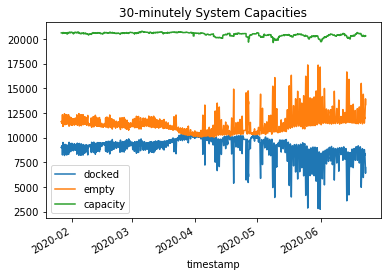

In [121]:
station_fill.groupby('timestamp').sum().drop('bikepoint_id',axis=1)\
    .plot(title='30-minutely System Capacities');

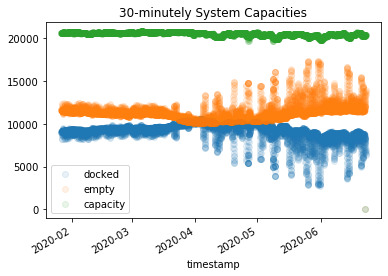

In [114]:
station_fill.groupby('timestamp').sum().drop('bikepoint_id',axis=1)\
    .plot(marker='o'
          ,linestyle=''
          ,alpha=0.1
          ,title='30-minutely System Capacities'
         );

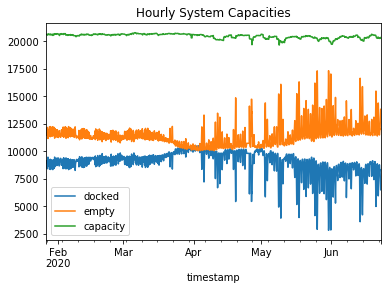

In [128]:
# groupby followed by resample to: sum bikepoints to system level, then average values per hour
station_fill \
    .groupby('timestamp').sum() \
    .resample('1H').mean() \
    .drop('bikepoint_id',axis=1).plot(title='Hourly System Capacities');

TODO: 
* Typical daily pattern for utilisation / load factor
* See if you can 'align' journey and station on the same timesequence.